In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import yaml
import glob
import plot_helper
from datasets import get_dataset, get_2d_samples
import utils
from nets import load_model
from losses import compute_acc

In [2]:
def glob_grid_experiments(directory):
    data = dict()
    for f in glob.glob(f"{directory}/*/*/summary.yml"):
        with open(f, "r") as fh:
            summary = yaml.safe_load(fh)
            key = "%s--%s--%s" % (summary["model"], summary["strategy"], str(summary["M"]))
            summary['path'] = "/".join(f.split("/")[:-1])
            data[key] = summary
    return data
    
data = glob_grid_experiments("../artifacts-server/hydra/experiment-mnist-2d-test-robustness")

In [3]:
data[list(data.keys())[0]]

{'M': 12,
 'beta': 0.001,
 'dataset': 'mnist',
 'epoch': 200,
 'lr': 0.0001,
 'metrics': {'test': {'I_XZ': 19.566408157348633,
   'I_YZ': 3.105313777923584,
   'accuracy_L1': 0.9761003851890564,
   'accuracy_L12': 0.9759001731872559,
   'loss': 0.2361806333065033},
  'train': {'I_XZ': 20.25094985961914,
   'I_YZ': 3.3157339096069336,
   'accuracy_L1': 1.0,
   'accuracy_L12': 1.0,
   'loss': 0.02644484117627144}},
 'model': 'vdb_fcov/e1:1024|e2:1024|z:2',
 'strategy': 'oneshot',
 'path': '../artifacts-server/hydra/experiment-mnist-2d-test-robustness/mnist-various-opts-M12/vdb_fcov-mnist--2019-12-19--03-27-24-322824'}

In [4]:
def alias(n):
    if n[:3] == "seq":
        return n.replace("seq", "algo1")
    elif n[:3] == "alt":
        k = n.split("/")[1].split("|")[0].split(":")[1]
        return f"algo2/k:{k}" 
    else:
        return n

In [5]:
alias("seq/d:20|e:1"), alias("alt/e:5|d:1")

('algo1/d:20|e:1', 'algo2/k:5')

In [6]:
def salt_paper_noise(x, p=0.1, extreme_values=(-1, 1)):
    shape = x.shape
    x = np.copy(x)
    flipping_cond = np.random.random_sample(x.shape) <= p
    x[flipping_cond] = np.random.choice(extreme_values, np.sum(flipping_cond))
    
    return x.reshape(shape)
    
salt_paper_noise(np.array([[-0.9, 0.5, 0.8, 0, 0.9], [0.7, 0.5, 0.8, 0, -0.5]]), p=0.6, extreme_values=(-1, 1))

array([[ 1. ,  0.5,  0.8, -1. ,  0.9],
       [ 0.7,  1. ,  0.8,  1. , -0.5]])

In [7]:
_, (test_images, test_labels), _ = get_dataset("mnist")

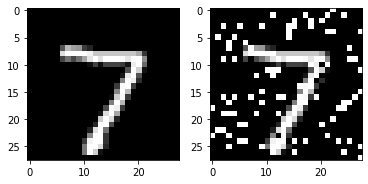

In [8]:
img = test_images[0,].reshape((28, 28))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")

plt.subplot(1, 2, 2)
plt.imshow(salt_paper_noise(img, p=0.2), cmap="gray")

In [23]:
arch = "vdb_fcov/e1:1024|e2:1024|z:2"

strategies = [
    "oneshot",
    "seq/d:5|e:1",
    "seq/d:10|e:1",
    "seq/d:20|e:1", "alt/e:5|d:1", "alt/e:10|d:1", "alt/e:20|d:1"
]

M = [1, 6, 12]

Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--oneshot--1
 acc: 0.9750 -> 0.9750
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--oneshot--6
 acc: 0.9750 -> 0.9760
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--oneshot--12
 acc: 0.9780 -> 0.9790
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:5|e:1--1
 acc: 0.9760 -> 0.9760
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:5|e:1--6
 acc: 0.9750 -> 0.9750
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:5|e:1--12
 acc: 0.9770 -> 0.9770
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:10|e:1--1
 acc: 0.9760 -> 0.9750
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:10|e:1--6
 acc: 0.9820 -> 0.9810
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:10|e:1--12
 acc: 0.9790 -> 0.9790
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:20|e:1--1
 acc: 0.9720 -> 0.9720
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:20|e:1--6
 acc: 0.9820 -> 0.9830
Taking nets.vdb_fcov
vdb_

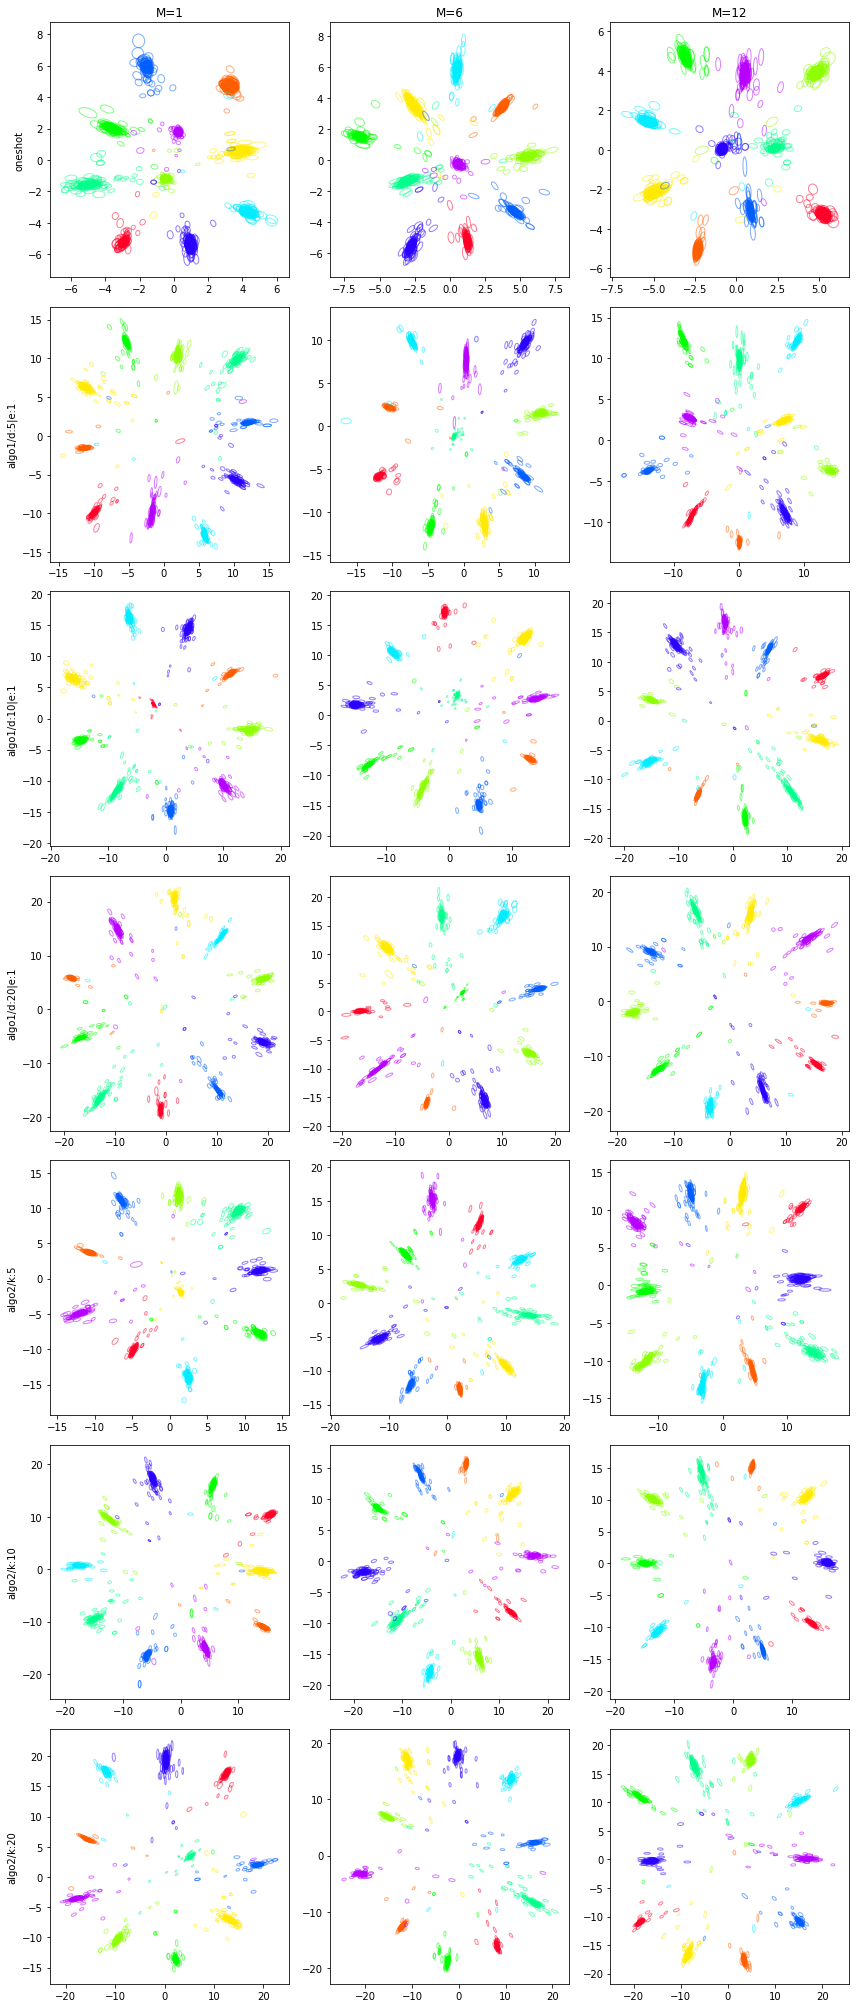

In [28]:
def plot(ax, mu, cov, labels, cm=plt.get_cmap('gist_rainbow')):
    for i in range(10):
        ix = np.argwhere(labels == i)
        ix = ix.reshape(-1)
        plt.scatter(mu[ix, 0], mu[ix, 1], color=cm(i/10), alpha=0.0, label=i)

        for j in range(ix.shape[0]):
            ij = ix[j]
            plot_helper.plot_ellipse(ax, mu[ij,:], cov[ij, :, :], edgecolor=cm(i/10))



def plot_grid(data, arch, strategies, M, p=0.1, L=12):
    total_strategies = len(strategies)
    total_M = len(M)
    
    dataset = data[list(data.keys())[0]]['dataset']
    _, (test_images, test_labels), _ = get_dataset(dataset)
    
    
    (test_images, test_labels), (subset_images, subset_labels) = get_2d_samples(dataset)

    extreme_values = np.min(test_images), np.max(test_images)
    subset_images_salt_paper = salt_paper_noise(subset_images, p=p, extreme_values=extreme_values)
    

    plt.figure(figsize=(4*total_M, 4*total_strategies))
    for i, s in enumerate(strategies):
        for j, m in enumerate(M):
            ax = plt.subplot(total_strategies, total_M, i*total_M + j+1)
            if i == 0:
                plt.title(f"M={m}")
            if j == 0:
                plt.ylabel(alias(s))
                
            # load model, add noise, plot
            key = f"{arch}--{s}--{m}"
            path = data[key]['path']

            model, _ = load_model(path)
            print("=======")
            print(key)
#             print(path)
            print(" acc: %.4f -> %.4f" % 
                  (
                      model.compute_acc(subset_images, subset_labels, L).numpy(),
                      model.compute_acc(subset_images_salt_paper, subset_labels, L).numpy(),
                  )
            )
            
            if p > 0:
                latent, _ = model(subset_images_salt_paper)
            else:
                latent, _ = model(subset_images)


            mu = latent.loc.numpy()
            cov = latent.covariance().numpy()
            
            plot(ax, mu, cov, subset_labels)
            

    plt.tight_layout()

    plt.savefig("./figures/2d-latent-salt-pepper-p%d.png" % (p*10))
plot_grid(data, arch, strategies, M, p=0.0)

Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--oneshot--1
 acc: 0.9750 -> 0.9460
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--oneshot--6
 acc: 0.9760 -> 0.9520
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--oneshot--12
 acc: 0.9780 -> 0.9570
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:5|e:1--1
 acc: 0.9760 -> 0.9530
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:5|e:1--6
 acc: 0.9750 -> 0.9570
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:5|e:1--12
 acc: 0.9770 -> 0.9630
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:10|e:1--1
 acc: 0.9760 -> 0.9510
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:10|e:1--6
 acc: 0.9820 -> 0.9540
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:10|e:1--12
 acc: 0.9790 -> 0.9610
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:20|e:1--1
 acc: 0.9720 -> 0.9530
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:20|e:1--6
 acc: 0.9820 -> 0.9650
Taking nets.vdb_fcov
vdb_

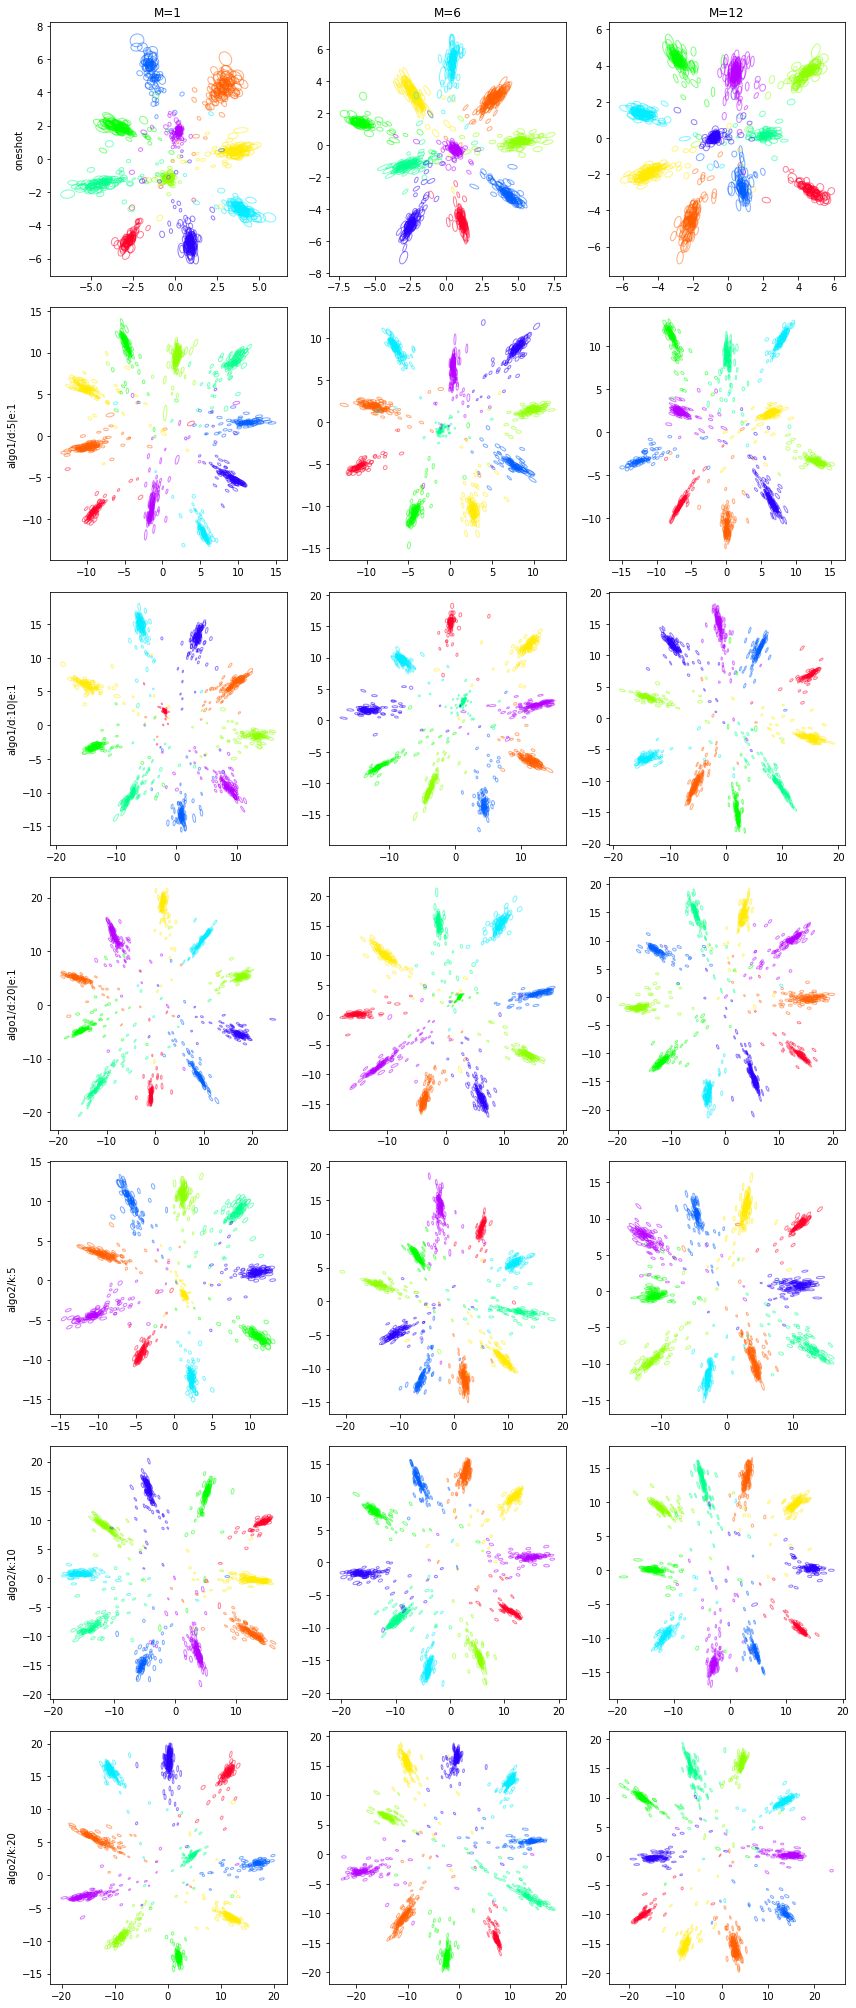

In [29]:
plot_grid(data, arch, strategies, M, p=0.1)

Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--oneshot--1
 acc: 0.9760 -> 0.8080
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--oneshot--6
 acc: 0.9760 -> 0.8260
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--oneshot--12
 acc: 0.9780 -> 0.8140
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:5|e:1--1
 acc: 0.9760 -> 0.8740
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:5|e:1--6
 acc: 0.9750 -> 0.8350
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:5|e:1--12
 acc: 0.9770 -> 0.8640
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:10|e:1--1
 acc: 0.9750 -> 0.8590
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:10|e:1--6
 acc: 0.9820 -> 0.8780
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:10|e:1--12
 acc: 0.9790 -> 0.8680
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:20|e:1--1
 acc: 0.9720 -> 0.8690
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:20|e:1--6
 acc: 0.9830 -> 0.8870
Taking nets.vdb_fcov
vdb_

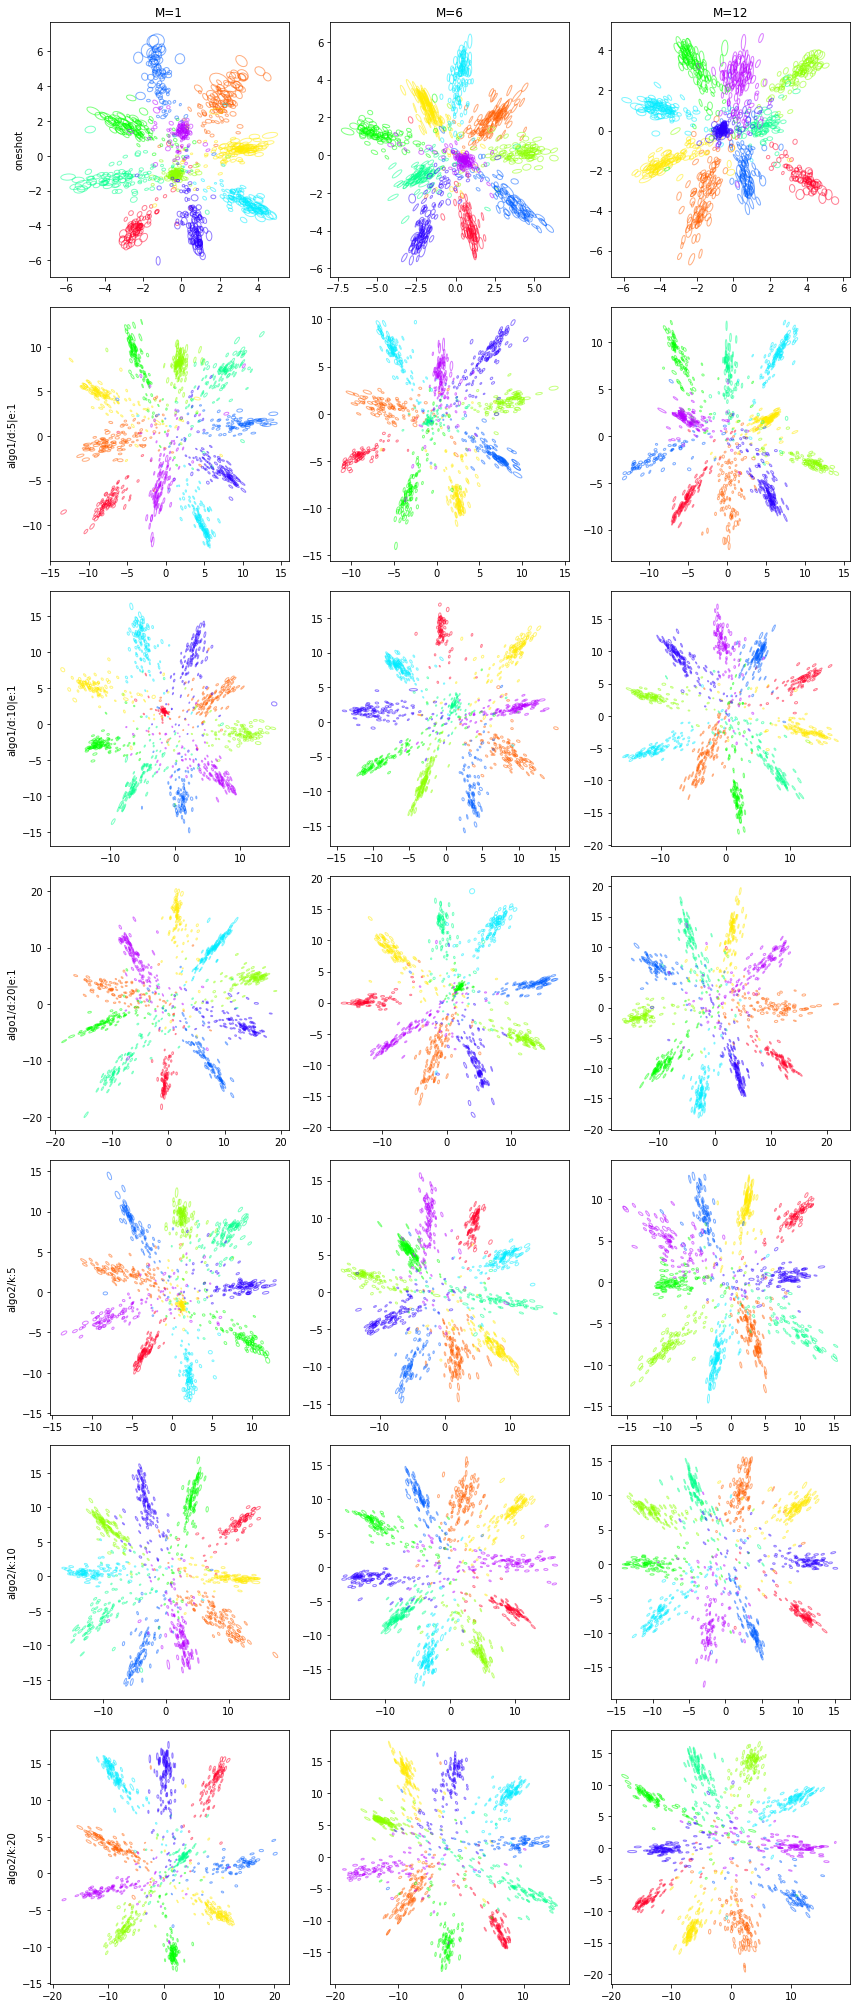

In [30]:
plot_grid(data, arch, strategies, M, p=0.25)

Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--oneshot--1
 acc: 0.9750 -> 0.5180
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--oneshot--6
 acc: 0.9750 -> 0.5250
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--oneshot--12
 acc: 0.9780 -> 0.4810
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:5|e:1--1
 acc: 0.9760 -> 0.6430
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:5|e:1--6
 acc: 0.9750 -> 0.5590
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:5|e:1--12
 acc: 0.9770 -> 0.5700
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:10|e:1--1
 acc: 0.9760 -> 0.6300
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:10|e:1--6
 acc: 0.9810 -> 0.6620
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:10|e:1--12
 acc: 0.9780 -> 0.6300
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:20|e:1--1
 acc: 0.9720 -> 0.6450
Taking nets.vdb_fcov
vdb_fcov/e1:1024|e2:1024|z:2--seq/d:20|e:1--6
 acc: 0.9820 -> 0.6460
Taking nets.vdb_fcov
vdb_

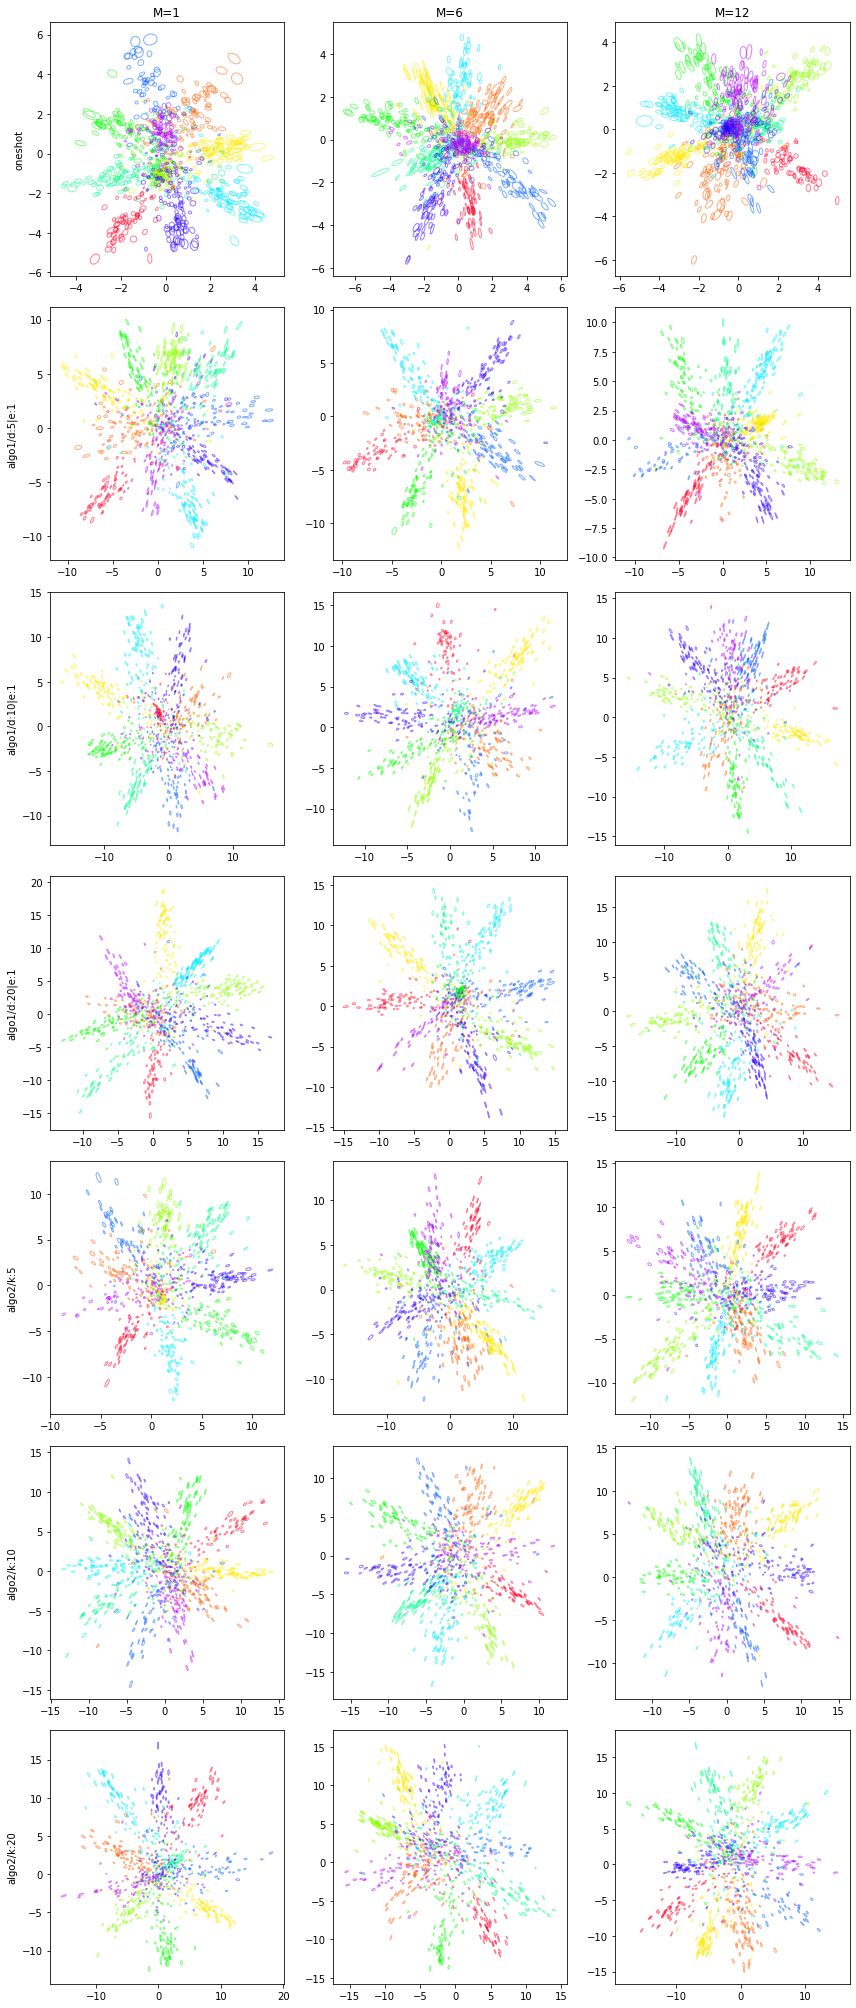

In [31]:
plot_grid(data, arch, strategies, M, p=0.4)